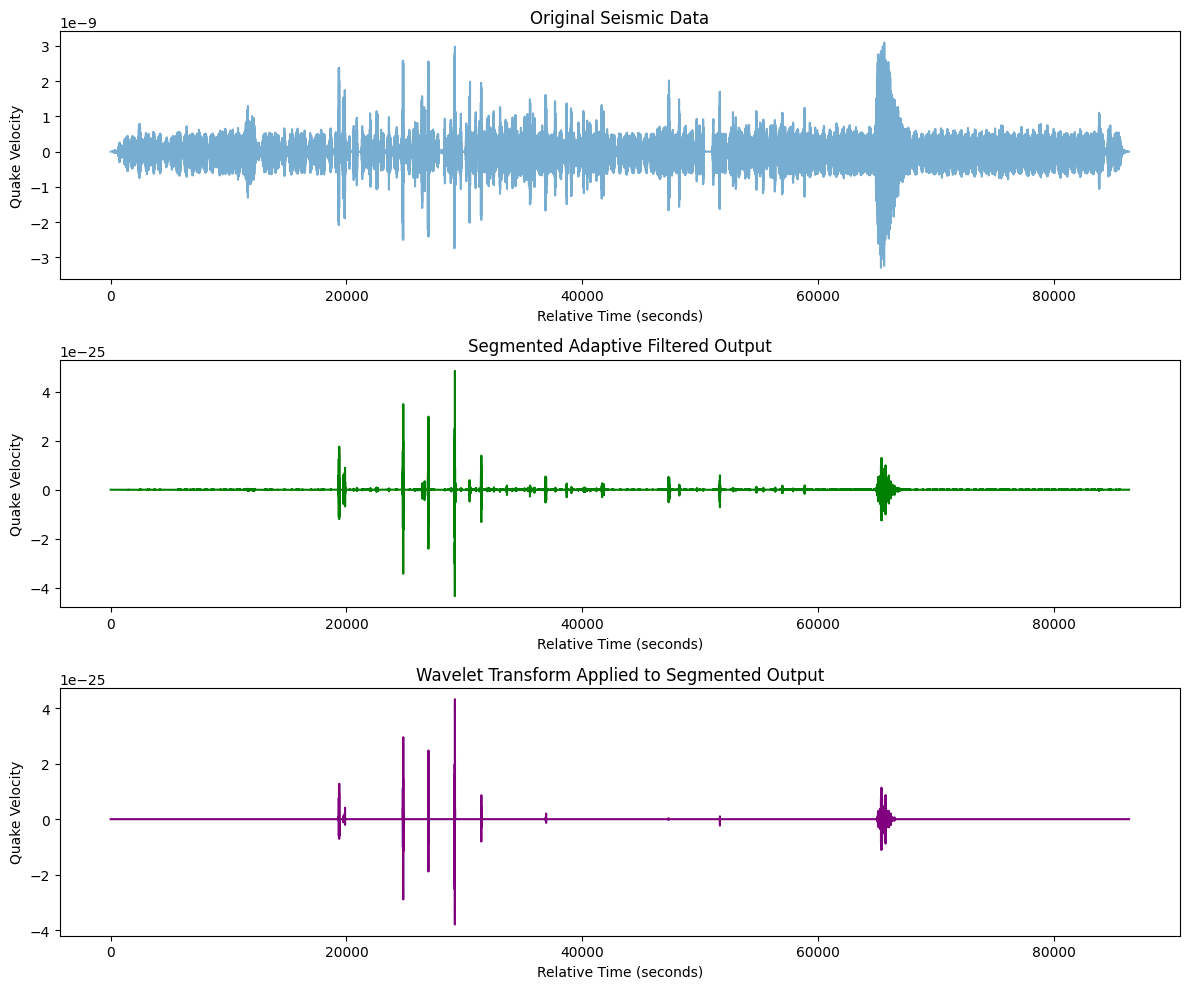

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import pywt  # Importing the PyWavelets library for wavelet transform

# Try reading it as a CSV
file_path = r"C:\Users\bilma\Documents\Nasa Hackathon\space_apps_2024_seismic_detection\data\lunar\training\data\S12_GradeA\xa.s12.00.mhz.1972-03-12HR00_evid00052.csv"
df = pd.read_csv(file_path, skiprows=1, header=None, names=["AbsoluteTime", "RelativeTime", "Velocity"])

# Drop the AbsoluteTime column, keep only relative time and velocity
df = df[["RelativeTime", "Velocity"]]

# Convert to numpy array for easier processing
data = df.to_numpy()

# Extract relative times and velocities
relative_times = data[:, 0]  # Relative time in seconds (starts from 0.0, increases with time)
velocities = data[:, 1]  # Quake velocity

### Adaptive LMS Filter Function ###
def lms_adaptive_filter(input_signal, desired_signal, mu=0.01, filter_order=32):
    """ 
    Apply LMS adaptive filtering.
    
    input_signal: The input (noisy) signal.
    desired_signal: The clean signal (reference).
    mu: Step size for LMS algorithm.
    filter_order: Number of coefficients in the filter.
    """
    # Initialize filter coefficients
    w = np.zeros(filter_order)
    # Initialize output and error signals
    output_signal = np.zeros(len(input_signal))
    error_signal = np.zeros(len(input_signal))

    # Apply the LMS algorithm
    for n in range(filter_order, len(input_signal)):
        # Extract the current input vector
        x_n = input_signal[n-filter_order:n]
        # Calculate the output of the adaptive filter
        output_signal[n] = np.dot(w, x_n)
        # Calculate the error
        error_signal[n] = desired_signal[n] - output_signal[n]
        # Update the filter coefficients
        w += mu * error_signal[n] * x_n

    return output_signal, error_signal

### Apply the LMS adaptive filter in segments ###
def apply_filter_in_segments(velocities, segment_size=0.01):
    num_segments = int(np.ceil(len(velocities) * segment_size))
    filtered_output = np.zeros_like(velocities)

    # Iterate through the segments
    for i in range(num_segments):
        start_index = int(i * len(velocities) / num_segments)
        end_index = int((i + 1) * len(velocities) / num_segments)
        
        # Extract the segment
        segment = velocities[start_index:end_index]
        
        # Create a desired signal using median filter for this segment
        desired_signal_segment = medfilt(segment, kernel_size=3)
        
        # Apply the LMS adaptive filter to this segment
        filtered_segment, _ = lms_adaptive_filter(segment, desired_signal_segment)
        
        # Store the filtered output
        filtered_output[start_index:end_index] = filtered_segment

    return filtered_output

### Wavelet Transform Filtering Function ###
def wavelet_filter(data, wavelet='haar', level=3, threshold=0.2):
    """
    Apply wavelet transform filtering to the input data.

    Parameters:
    - data: Input data array (1D).
    - wavelet: The type of wavelet to use (default is 'haar').
    - level: The level of decomposition (default is 1).
    - threshold: The threshold for wavelet coefficients (default is 0.1).

    Returns:
    - filtered: Wavelet filtered data.
    """
    # Perform the discrete wavelet transform
    coeffs = pywt.wavedec(data, wavelet, level=level)
    
    # Apply thresholding to the coefficients
    coeffs_thresholded = [pywt.threshold(c, threshold * np.max(np.abs(c)), mode='soft') for c in coeffs]

    # Reconstruct the signal using the thresholded coefficients
    filtered = pywt.waverec(coeffs_thresholded, wavelet)

    # Adjust length to match original data
    if len(filtered) > len(data):
        return filtered[:len(data)]
    elif len(filtered) < len(data):
        return np.pad(filtered, (0, len(data) - len(filtered)), mode='constant')

    return filtered

# Apply the adaptive filter in segments
filtered_output_segments = apply_filter_in_segments(velocities, segment_size=0.001)

# Apply the Wavelet Transform filter on the segmented adaptive filtered output
wavelet_filtered_output = wavelet_filter(filtered_output_segments, wavelet='haar', level=2, threshold=0.1)

### Plotting the Results ###
plt.figure(figsize=(12, 10))

# Original Data
plt.subplot(3, 1, 1)
plt.plot(df["RelativeTime"], velocities, label="Original Data", alpha=0.6)
plt.title("Original Seismic Data")
plt.xlabel("Relative Time (seconds)")
plt.ylabel("Quake Velocity")

# Filtered Output (Segmented Adaptive Filter)
plt.subplot(3, 1, 2)
plt.plot(df["RelativeTime"], filtered_output_segments, label="Filtered Output (Segmented LMS)", color='green')
plt.title("Segmented Adaptive Filtered Output")
plt.xlabel("Relative Time (seconds)")
plt.ylabel("Quake Velocity")

# Final Wavelet Filtered Output
plt.subplot(3, 1, 3)
plt.plot(df["RelativeTime"], wavelet_filtered_output, label="Wavelet Filtered Output", color='purple')
plt.title("Wavelet Transform Applied to Segmented Output")
plt.xlabel("Relative Time (seconds)")
plt.ylabel("Quake Velocity")

plt.tight_layout()
plt.show()
